# Peres

## Importing libraries

In [32]:
# Importing essential libraries
import numpy as np, matplotlib.pyplot as plt, random, time
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter
import time
import statistics

## Generating random angles

In [3]:
# Number of shots and z-score for confidence interval
N_SHOTS = 10_000
Z_SCORE = 3

# Generating random angles
e=0
def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
    
    Returns:
        A list of three tuples. The first element of each tuple is the value of theta 
        and the second element is the value of phi.
    
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)

## Circuit construction

In [4]:
# The circuit for constructing the product state and measuring in Bell basis.
def circuit_bell(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
#     thetam = circ.declare('thetam', 'REAL', 1)
    phi = circ.declare('phi', 'REAL', 2)
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(phi[1], qubit2)
    
    # Measuring in psi+ basis
    # REMOVED FOR TEST OF SIMPLER CIRCUIT
    circ += CNOT(qubit1, qubit2)
#     circ += RY(qubit1, thetam)
    circ += H(qubit1)

    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    return circ

# The circuit for constructing the product state and measuring in Computational basis.
def circuit_comp(qubit1, qubit2):
    circ = Program()
    
    c = circ.declare('ro', 'BIT', 2)
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    
    # Preparation of states.
    circ += RY(theta[0], qubit1)
    circ += RZ(phi[0], qubit1)
    
    circ += RY(theta[1], qubit2)
    circ += RZ(phi[1], qubit2)
    
    circ += MEASURE(qubit1, c[0])
    circ += MEASURE(qubit2, c[1])
    
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    return circ

## Theoretical probabilities

In [6]:
# The theoretical probabilities
def theoretical_probs(state_params):
    theta, phi = tuple(map(list, zip(*state_params)))
        
    probs = {
        'P_12': (1/2) * np.abs(np.cos(theta[0]/2) * np.sin(theta[1]/2) * np.exp(1j*(phi[1] - phi[0])/2) + np.sin(theta[0]/2) * np.cos(theta[1]/2) * np.exp(-1j*(phi[1]-phi[0])/2))**2,
        'P_12_1': np.abs(np.cos(theta[0]/2) * np.sin(theta[1]/2))**2,
        'P_12_2': np.abs(np.sin(theta[0]/2) * np.cos(theta[1]/2))**2,
        
        'P_23': (1/2) * np.abs(np.cos(theta[1]/2) * np.sin(theta[2]/2) * np.exp(1j*(phi[2] - phi[1])/2) + np.sin(theta[1]/2) * np.cos(theta[2]/2) * np.exp(-1j*(phi[2]-phi[1])/2))**2,
        'P_23_1': np.abs(np.cos(theta[1]/2) * np.sin(theta[2]/2))**2,
        'P_23_2': np.abs(np.sin(theta[1]/2) * np.cos(theta[2]/2))**2,
        
        'P_31': (1/2) * np.abs(np.cos(theta[2]/2) * np.sin(theta[0]/2) * np.exp(1j*(phi[0] - phi[2])/2) + np.sin(theta[2]/2) * np.cos(theta[0]/2) * np.exp(-1j*(phi[0]-phi[2])/2))**2,
        'P_31_1': np.abs(np.cos(theta[2]/2) * np.sin(theta[0]/2))**2,
        'P_31_2': np.abs(np.sin(theta[2]/2) * np.cos(theta[0]/2))**2
    }
    
#     probs['Kappa'] = 3 * probs['P_123'] - 2 * (probs['P_12'] + probs['P_23'] + probs['P_31']) + probs['P_1'] + probs['P_2'] + probs['P_3']
    
    return probs

In [66]:
# Getting the theoretical fluctuations with 1000 repetitions of the same circuit
ci_a = 0.005
ci_b = 1 - ci_a
def get_ci(state_list):
    ci_list = []
    v_list = []
    for state in state_list:
        probs = theoretical_probs(state['State_params'])
        g12_list = []
        g23_list = []
        g31_list = []
        f_list = []
        for i in range(1000):
            c12 = Counter(random.choices(['0','1'], weights=[probs['P_12'], 1-probs['P_12']], k=N_SHOTS))['0']
            c12_Singles = Counter(random.choices(['0','1','2'], weights=[probs['P_12_1'], probs['P_12_2'], 1-probs['P_12_1']-probs['P_12_2']], k=N_SHOTS))
            g12 = (2*c12 - c12_Singles['0'] - c12_Singles['1']) / (2 * np.sqrt(c12_Singles['0'] * c12_Singles['1']))
            
            c23 = Counter(random.choices(['0','1'], weights=[probs['P_23'], 1-probs['P_23']], k=N_SHOTS))['0']
            c23_Singles = Counter(random.choices(['0','1','2'], weights=[probs['P_23_1'], probs['P_23_2'], 1-probs['P_23_1']-probs['P_23_2']], k=N_SHOTS))
            g23 = (2*c23 - c23_Singles['0'] - c23_Singles['1']) / (2 * np.sqrt(c23_Singles['0'] * c23_Singles['1']))
            
            c31 = Counter(random.choices(['0','1'], weights=[probs['P_31'], 1-probs['P_31']], k=N_SHOTS))['0']
            c31_Singles = Counter(random.choices(['0','1','2'], weights=[probs['P_31_1'], probs['P_31_2'], 1-probs['P_31_1']-probs['P_31_2']], k=N_SHOTS))
            g31 = (2*c31 - c31_Singles['0'] - c31_Singles['1']) / (2 * np.sqrt(c31_Singles['0'] * c31_Singles['1']))
            
            f = g12**2 + g23**2 + g31**2 - 2*g12*g23*g31
            
            g12_list.append(g12)
            g23_list.append(g23)
            g31_list.append(g31)
            f_list.append(f)
        
        g12_list.sort()
        g23_list.sort()
        g31_list.sort()
        f_list.sort()
#         ci = [k_list[int(ci_a*len(k_list))], k_list[int(ci_b*len(k_list)) - 1]]#
        g12ci = [g12_list[int(0+ci_a*len(g12_list))], g12_list[int(len(g12_list) - 1 - ci_a*len(g12_list))]]
        g23ci = [g23_list[int(0+ci_a*len(g23_list))], g23_list[int(len(g23_list) - 1 - ci_a*len(g23_list))]]
        g31ci = [g31_list[int(0+ci_a*len(g31_list))], g31_list[int(len(g31_list) - 1 - ci_a*len(g31_list))]]
        fci = [f_list[int(0+ci_a*len(f_list))], f_list[int(len(f_list) - 1 - ci_a*len(f_list))]]
        # ci = [k_list[int(0.00*len(k_list))], k_list[int(1*(len(k_list)-1))]]
#         ci_list.append(ci)
        state['Theory'] = {'g12': {}, 'g23': {}, 'g31': {}, 'f': {}}
        state['Theory']['g12']['val'] = statistics.mean(g12_list)#(g12ci[0] + g12ci[1])/2
        state['Theory']['g12']['ci'] = g12ci
        
        state['Theory']['g23']['val'] = statistics.mean(g23_list)#(g23ci[0] + g23ci[1])/2
        state['Theory']['g23']['ci'] = g23ci
        
        state['Theory']['g31']['val'] = statistics.mean(g31_list)#(g31ci[0] + g31ci[1])/2
        state['Theory']['g31']['ci'] = g31ci
        
        state['Theory']['f']['val'] = statistics.mean(f_list)#(fci[0] + fci[1])/2
        state['Theory']['f']['ci'] = fci
        
        print(f'Done with state no. {state_list.index(state)}', end='\r')
#         v_list.append(max(k_list))

    return state_list

In [67]:
# Generate random states
states = [{'State_params': params_complex()} for _ in range(10)]
states = get_ci(states)

(0.8, 1.2)

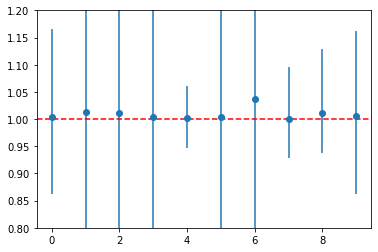

In [68]:
quant = 'f'
x = np.arange(len(states))
y = np.array([states[i]['Theory'][quant]['val'] for i in range(len(states))])
yerr = np.array([states[i]['Theory'][quant]['ci'] for i in range(len(states))])

plt.errorbar(x, y, yerr=[y - yerr[:,0], yerr[:,1] - y], marker='o', ls='')
# plt.plot(x,y)
plt.axhline(y=1, ls='dashed', color='red')
plt.ylim([0.8, 1.2])

In [15]:
def run_circuit(states, engine):
    '''
    Compile and run the circuit given the parameters. The list of outputs is returned.
    '''
    for state in states:
        state[engine] = {}
        theta, phi = tuple(map(list, zip(*state['State_params'])))
        
        # Config 12
        circ = circuit_bell(q1, q2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta':[theta[0], theta[1]], 'phi': [phi[0], phi[1]]})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_12'] = np.array(clicks)
        state[engine]['Counts_12'] = Counter(clicks)['01']
        
        circ = circuit_comp(q1, q2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta':[theta[0], theta[1]], 'phi': [phi[0], phi[1]]})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_12_Singles'] = np.array(clicks)
        state[engine]['Counts_12_Singles'] = Counter(clicks)
        
        # Config 23
        circ = circuit_bell(q1, q2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta':[theta[1], theta[2]], 'phi': [phi[1], phi[2]]})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_23'] = np.array(clicks)
        state[engine]['Counts_23'] = Counter(clicks)['01']
        
        circ = circuit_comp(q1, q2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta':[theta[1], theta[2]], 'phi': [phi[1], phi[2]]})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_23_Singles'] = np.array(clicks)
        state[engine]['Counts_23_Singles'] = Counter(clicks)
        
        # Config 31
        circ = circuit_bell(q1, q2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta':[theta[2], theta[0]], 'phi': [phi[2], phi[0]]})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_31'] = np.array(clicks)
        state[engine]['Counts_31'] = Counter(clicks)['01']
        
        circ = circuit_comp(q1, q2)
        exe = qc.compile(circ)
        
        clicks = qc.run(exe, memory_map={'theta':[theta[2], theta[0]], 'phi': [phi[2], phi[0]]})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_31_Singles'] = np.array(clicks)
        state[engine]['Counts_31_Singles'] = Counter(clicks)
        
        
#         outcomes['Singles'] = Counter(tmp)
        state[engine]['g12'] = {}
        state[engine]['g23'] = {}
        state[engine]['g31'] = {}
        state[engine]['f'] = {}
        
        state[engine]['g12']['val'] = (2*state[engine]['Counts_12'] - state[engine]['Counts_12_Singles']['01'] - state[engine]['Counts_12_Singles']['01']) / (2*np.sqrt(state[engine]['Counts_12_Singles']['01'] * state[engine]['Counts_12_Singles']['01']))
        state[engine]['g23']['val'] = (2*state[engine]['Counts_23'] - state[engine]['Counts_23_Singles']['01'] - state[engine]['Counts_23_Singles']['01']) / (2*np.sqrt(state[engine]['Counts_23_Singles']['01'] * state[engine]['Counts_23_Singles']['01']))
        state[engine]['g31']['val'] = (2*state[engine]['Counts_31'] - state[engine]['Counts_31_Singles']['01'] - state[engine]['Counts_31_Singles']['01']) / (2*np.sqrt(state[engine]['Counts_31_Singles']['01'] * state[engine]['Counts_31_Singles']['01']))
        state[engine]['f']['val'] = state[engine]['g12']['val']**2 + state[engine]['g23']['val']**2 + state[engine]['g31']['val']**2 - 2 * state[engine]['g12']['val'] * state[engine]['g23']['val'] * state[engine]['g31']['val']
    
    return states

In [40]:
statistics.mode([1,2,3,3,3,4,5,1,1,1,1,1,1])

1